
Evaluating STING clustering for Car Data


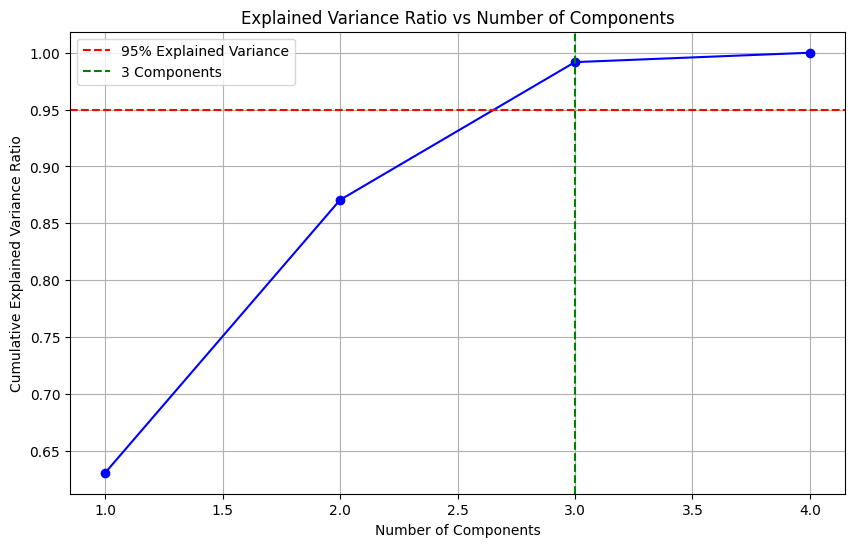

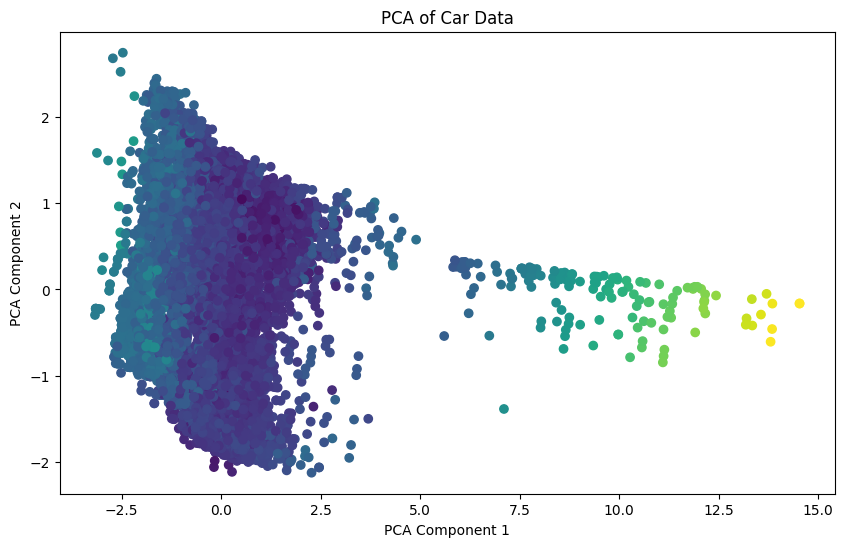

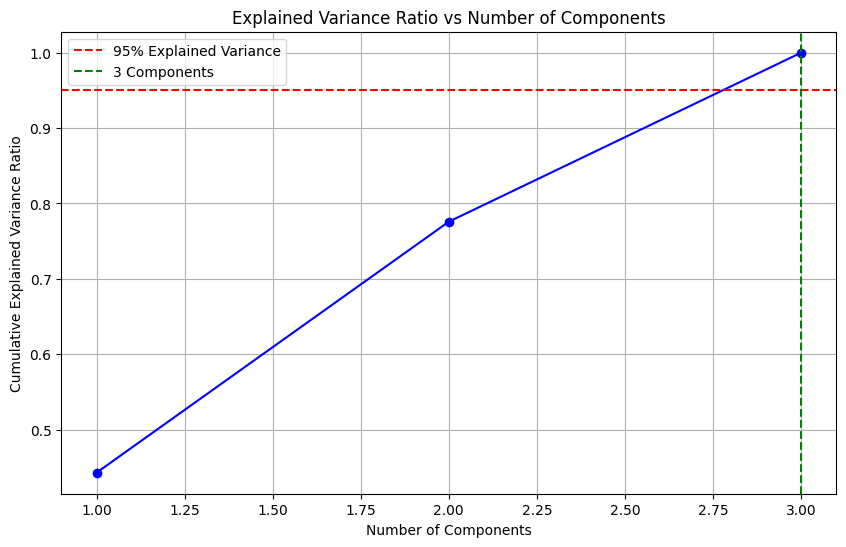

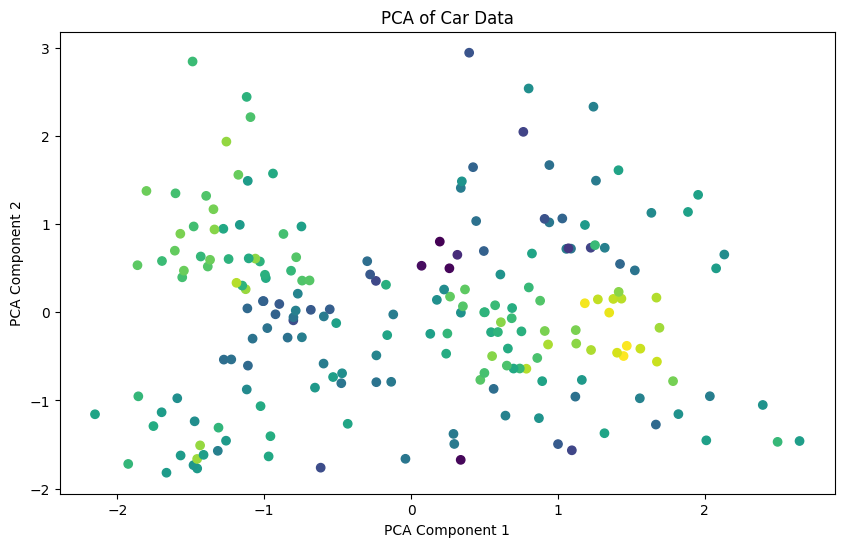

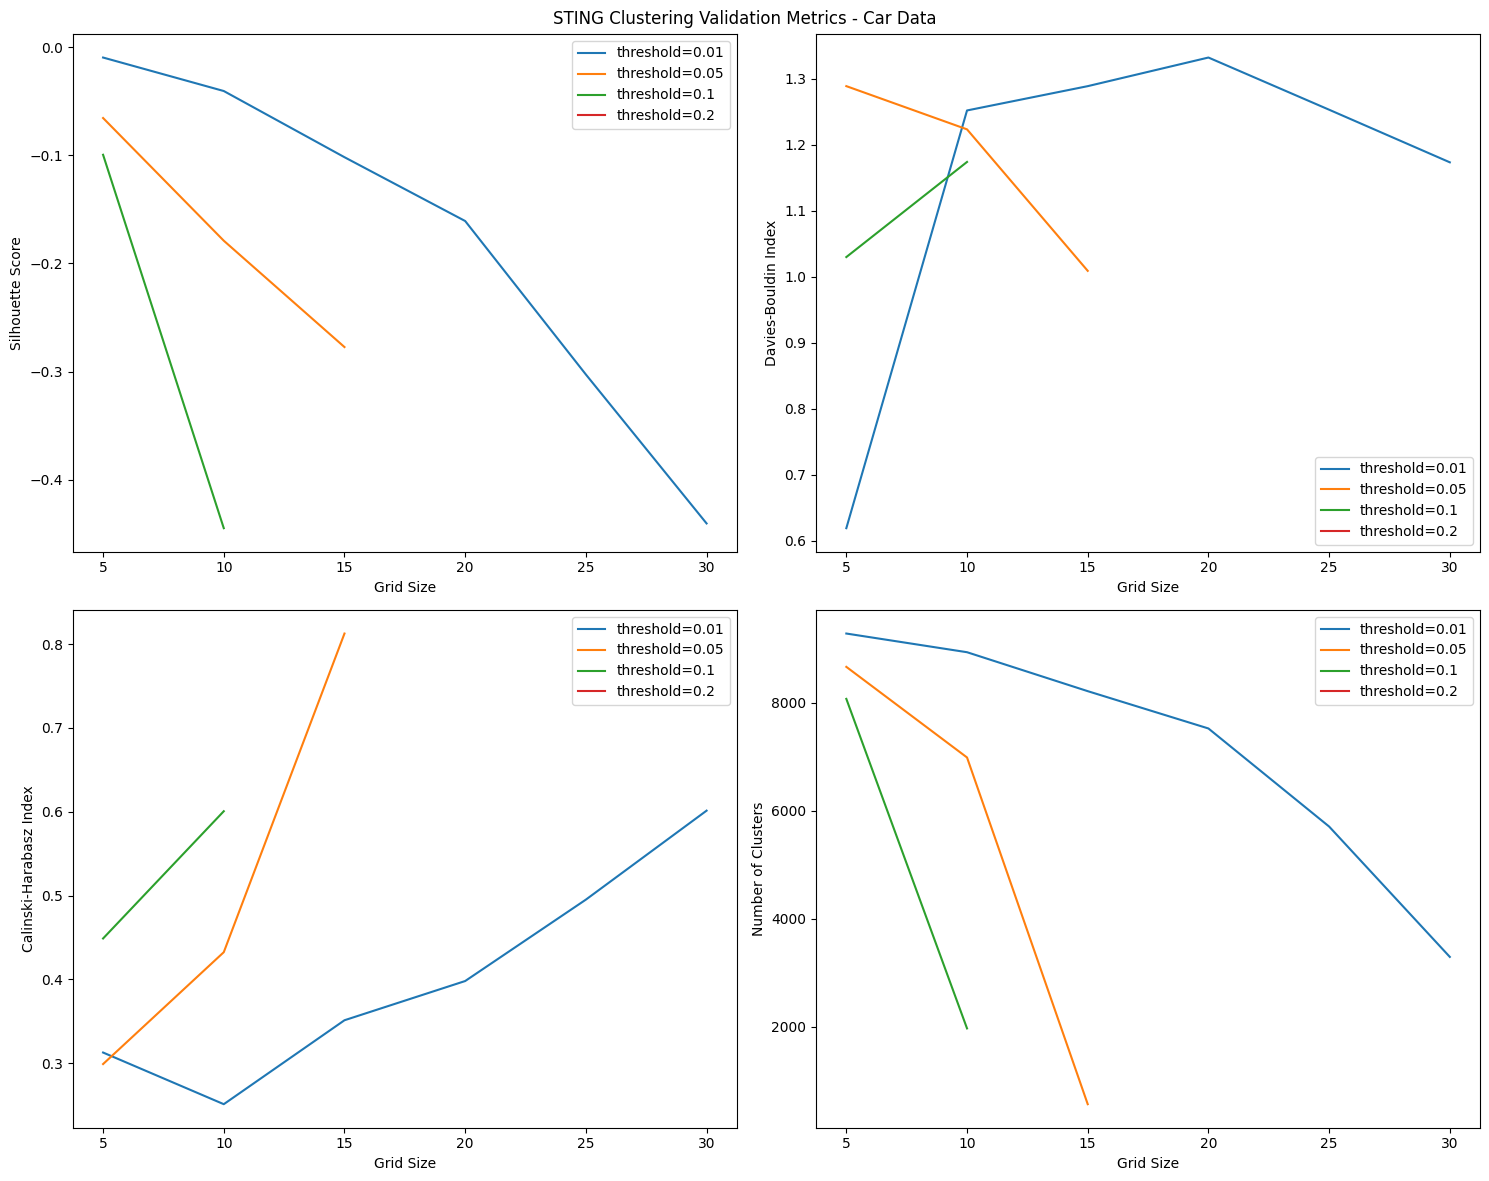


Best parameters:
Grid size: 5
Threshold: 0.01
Number of clusters: 9283

Validation metrics:
Silhouette Score: -0.0094
Davies-Bouldin Index: 0.6192
Calinski-Harabasz Index: 0.3126


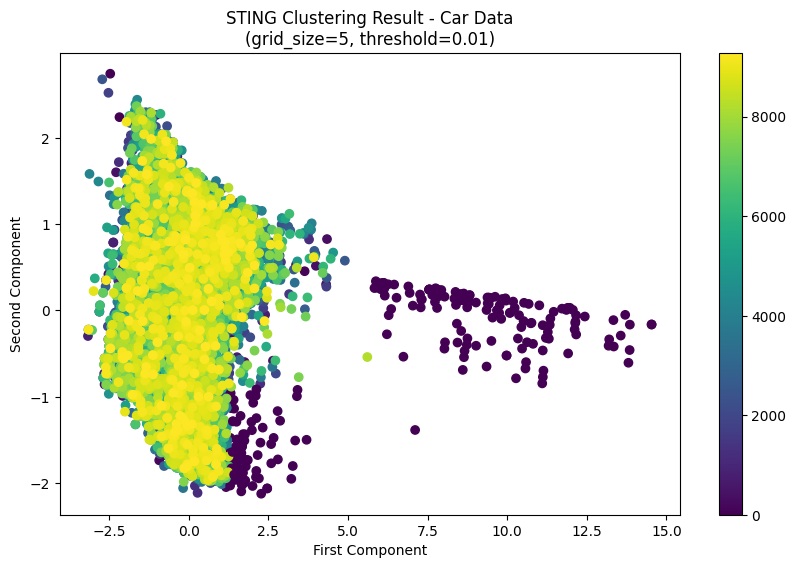

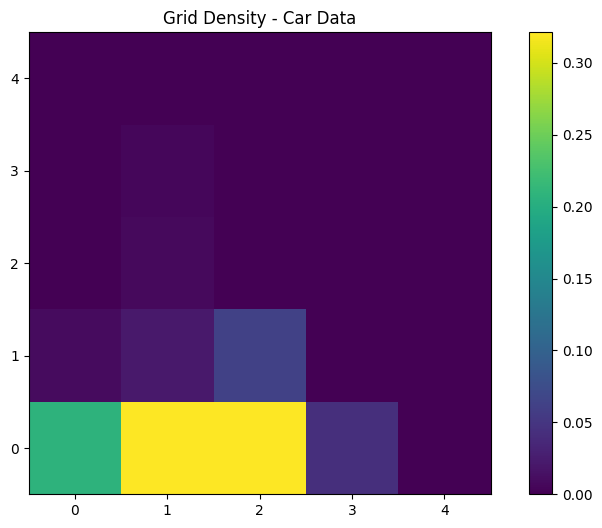


Evaluating STING clustering for Customer Data


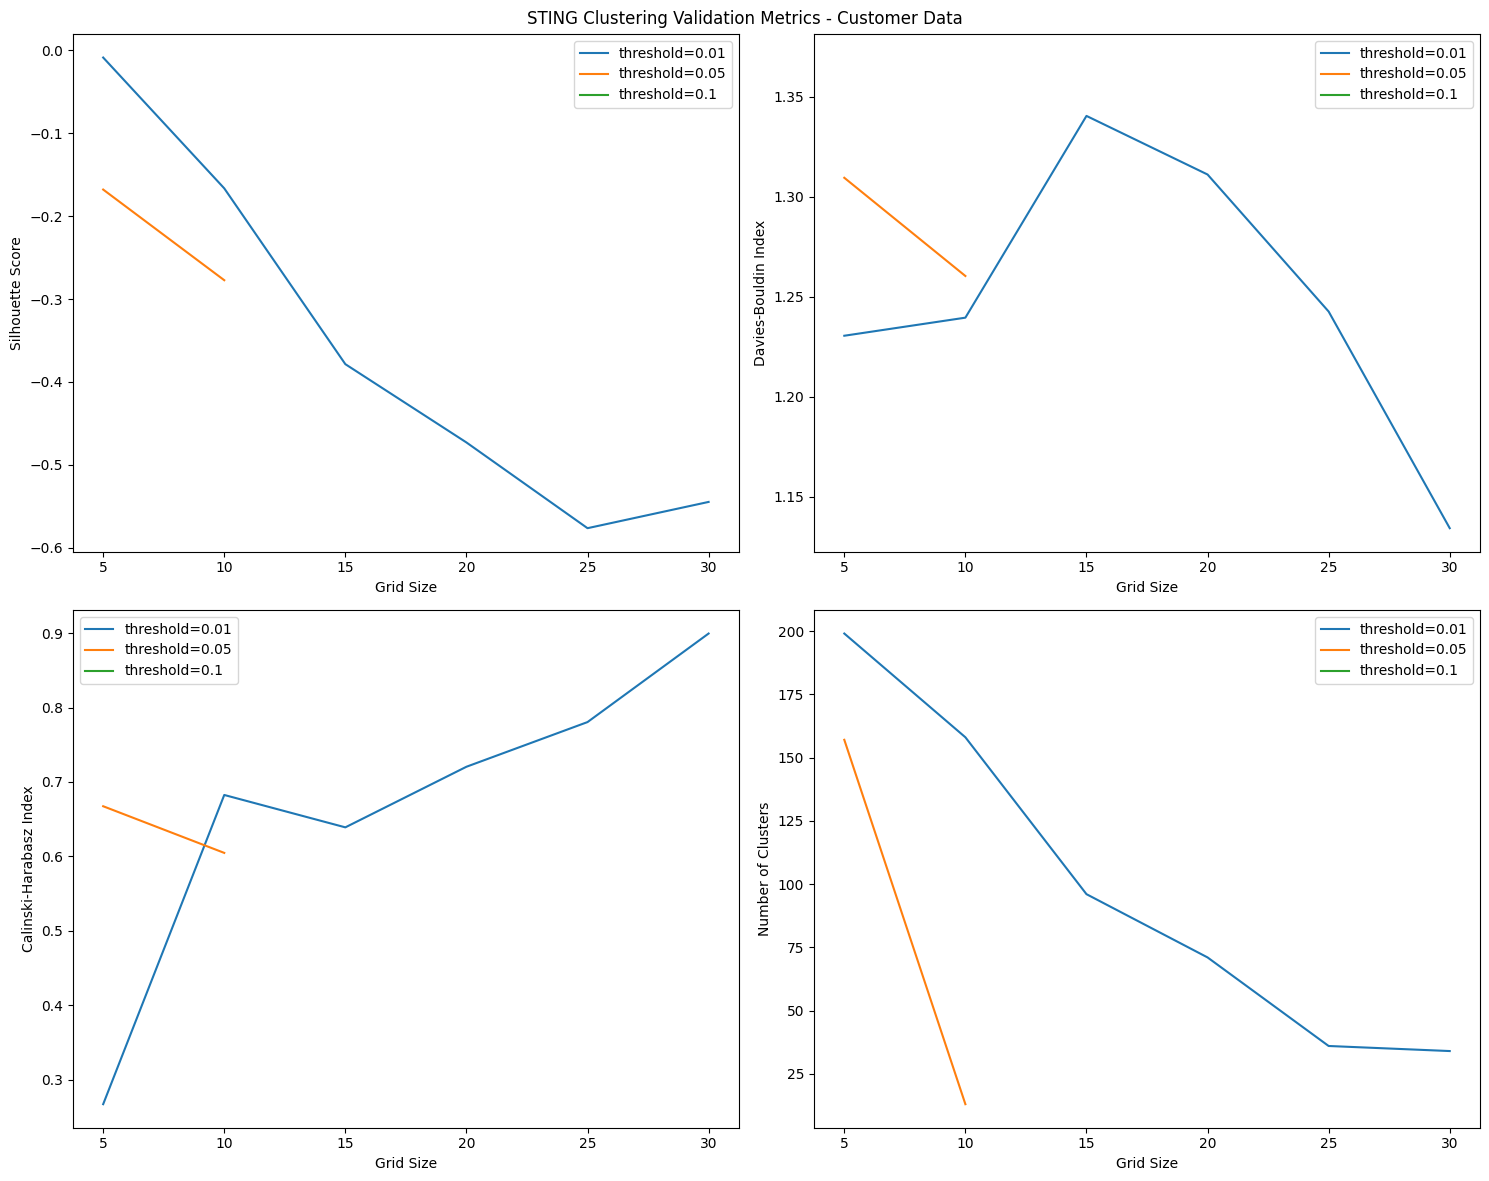


Best parameters:
Grid size: 5
Threshold: 0.01
Number of clusters: 199

Validation metrics:
Silhouette Score: -0.0086
Davies-Bouldin Index: 1.2305
Calinski-Harabasz Index: 0.2674


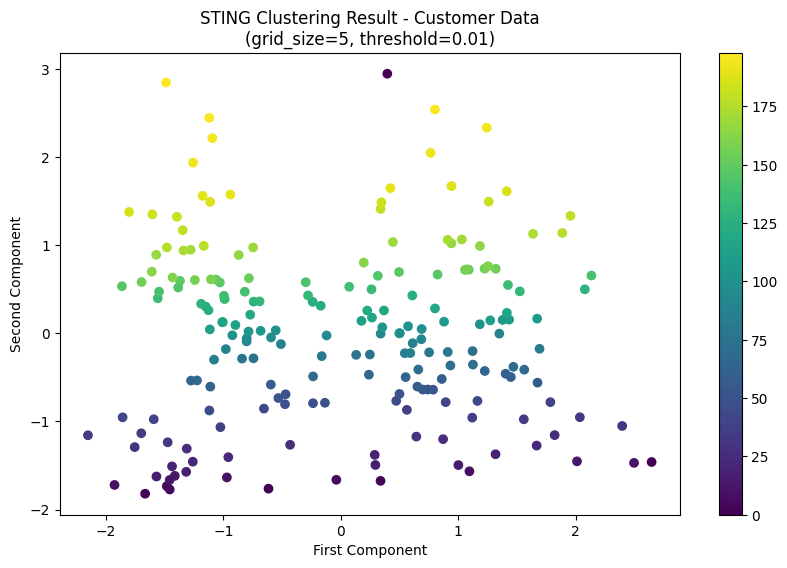

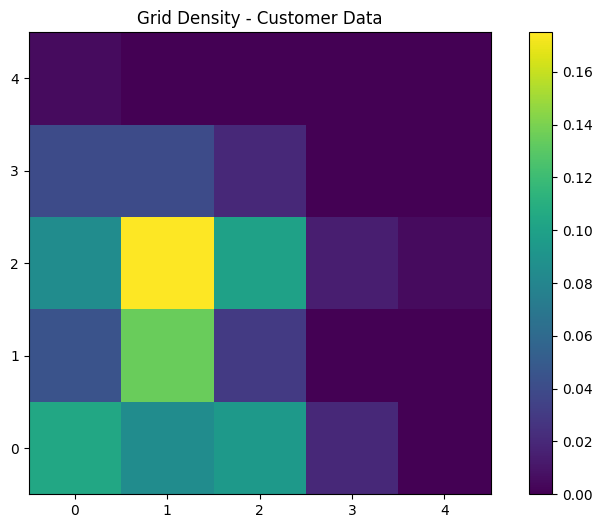

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from src.prep import Prep
import os

if not os.path.exists('figs'):
    os.makedirs('figs')
class STINGClustering:
    def __init__(self, threshold=0.1, grid_size=10):
        """
        Initialize STING clustering
        
        Parameters:
        threshold: float - density threshold for identifying dense cells
        grid_size: int - number of grid cells per dimension
        """
        self.threshold = threshold
        self.grid_size = grid_size
        self.labels_ = None
        
    def fit_predict(self, X):
        """
        Perform STING clustering on data
        
        Parameters:
        X: array-like - input data (n_samples, n_features)
        
        Returns:
        labels: array - cluster labels for each point
        """
        # Standardize the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Create grid
        self.grid = np.zeros((self.grid_size, self.grid_size))
        
        # Find data bounds
        x_min, x_max = X_scaled[:, 0].min(), X_scaled[:, 0].max()
        y_min, y_max = X_scaled[:, 1].min(), X_scaled[:, 1].max()
        
        # Assign points to grid cells
        for point in X_scaled:
            x_idx = int((point[0] - x_min) / (x_max - x_min) * (self.grid_size - 1))
            y_idx = int((point[1] - y_min) / (y_max - y_min) * (self.grid_size - 1))
            self.grid[x_idx, y_idx] += 1
        
        # Normalize grid
        self.grid = self.grid / len(X)
        
        # Find dense cells
        dense_cells = self.grid > self.threshold
        
        # Assign cluster labels
        labels = np.zeros(len(X))
        cluster_id = 1
        
        for i in range(len(X)):
            point = X_scaled[i]
            x_idx = int((point[0] - x_min) / (x_max - x_min) * (self.grid_size - 1))
            y_idx = int((point[1] - y_min) / (y_max - y_min) * (self.grid_size - 1))
            
            if dense_cells[x_idx, y_idx]:
                labels[i] = cluster_id
                cluster_id += 1
            
        self.labels_ = labels
        return labels

# Load and prepare data
prep = Prep(output_pca=True)
car_data = prep.prep_car
customer_data = prep.prep_customer

def evaluate_sting(data, grid_sizes, thresholds):
    """
    Evaluate STING clustering with different parameters
    """
    results = []
    
    for grid_size in grid_sizes:
        for threshold in thresholds:
            sting = STINGClustering(threshold=threshold, grid_size=grid_size)
            labels = sting.fit_predict(data)
            
            # Skip if only one cluster is found
            if len(np.unique(labels)) < 2:
                continue
                
            metrics = {
                'grid_size': grid_size,
                'threshold': threshold,
                'silhouette': silhouette_score(data, labels),
                'davies_bouldin': davies_bouldin_score(data, labels),
                'calinski_harabasz': calinski_harabasz_score(data, labels),
                'n_clusters': len(np.unique(labels))
            }
            results.append(metrics)
    
    return pd.DataFrame(results)

def plot_validation_metrics(results, title):
    """
    Plot validation metrics for STING clustering
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'STING Clustering Validation Metrics - {title}')
    
    # Plot metrics vs grid size
    for threshold in results['threshold'].unique():
        mask = results['threshold'] == threshold
        axes[0, 0].plot(results[mask]['grid_size'], 
                       results[mask]['silhouette'], 
                       label=f'threshold={threshold}')
    axes[0, 0].set_xlabel('Grid Size')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].legend()
    
    for threshold in results['threshold'].unique():
        mask = results['threshold'] == threshold
        axes[0, 1].plot(results[mask]['grid_size'], 
                       results[mask]['davies_bouldin'], 
                       label=f'threshold={threshold}')
    axes[0, 1].set_xlabel('Grid Size')
    axes[0, 1].set_ylabel('Davies-Bouldin Index')
    axes[0, 1].legend()
    
    for threshold in results['threshold'].unique():
        mask = results['threshold'] == threshold
        axes[1, 0].plot(results[mask]['grid_size'], 
                       results[mask]['calinski_harabasz'], 
                       label=f'threshold={threshold}')
    axes[1, 0].set_xlabel('Grid Size')
    axes[1, 0].set_ylabel('Calinski-Harabasz Index')
    axes[1, 0].legend()
    
    for threshold in results['threshold'].unique():
        mask = results['threshold'] == threshold
        axes[1, 1].plot(results[mask]['grid_size'], 
                       results[mask]['n_clusters'], 
                       label=f'threshold={threshold}')
    axes[1, 1].set_xlabel('Grid Size')
    axes[1, 1].set_ylabel('Number of Clusters')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Evaluate clustering for both datasets
grid_sizes = range(5, 31, 5)
thresholds = [0.01, 0.05, 0.1, 0.2]
datasets = {
    'Car Data': car_data,
    'Customer Data': customer_data
}

for name, data in datasets.items():
    print(f"\nEvaluating STING clustering for {name}")
    
    # Compute and plot validation metrics
    results = evaluate_sting(data, grid_sizes, thresholds)
    plot_validation_metrics(results, name)
    
    # Find best parameters
    best_result = results.loc[results['silhouette'].idxmax()]
    
    print("\nBest parameters:")
    print(f"Grid size: {int(best_result['grid_size'])}")
    print(f"Threshold: {best_result['threshold']}")
    print(f"Number of clusters: {int(best_result['n_clusters'])}")
    print("\nValidation metrics:")
    print(f"Silhouette Score: {best_result['silhouette']:.4f}")
    print(f"Davies-Bouldin Index: {best_result['davies_bouldin']:.4f}")
    print(f"Calinski-Harabasz Index: {best_result['calinski_harabasz']:.4f}")
    
    # Plot final clustering with best parameters
    sting = STINGClustering(
        threshold=best_result['threshold'],
        grid_size=int(best_result['grid_size'])
    )
    labels = sting.fit_predict(data)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, cmap='viridis')
    plt.title(f'STING Clustering Result - {name}\n' + 
             f'(grid_size={int(best_result["grid_size"])}, ' +
             f'threshold={best_result["threshold"]})')
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.colorbar()
    plt.show()
    
    # Plot grid density
    plt.figure(figsize=(10, 6))
    plt.imshow(sting.grid, cmap='viridis', origin='lower')
    plt.title(f'Grid Density - {name}')
    plt.colorbar()
    plt.show()